In [26]:
import torch
import torch.nn as nn
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from joblib import dump,load
import time
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.io import loadmat
import scipy.io
'''
from google.colab import drive
drive.mount('/content/drive')'''

global device, print_freq
device = torch.device('cuda')

In [27]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, inp, out):
        self.inp = inp
        self.out = out

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self, index):
        return self.inp[index], self.out[index]

class MyDataset2(torch.utils.data.Dataset):

    def __init__(self, inp):
        self.inp = inp

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self, index):
        return self.inp[index]


class AverageMeter(object):
    # Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [28]:
def train_step(train_loader, model, criterion, optimizer, epoch, net_info):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.to(device)
        target = target.to(device)

        # compute output
        output = model(input)
        
     
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward(retain_graph=True)

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:

            if i % print_freq == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                print('Epoch: [{0}/{1}][{2}/{3}]\t'
                    'LR: {4}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.6f})\t'.format(
                    epoch, net_info['epochs'], i, len(train_loader), curr_lr,
                    batch_time=batch_time, data_time=data_time, loss=losses))

    return losses.avg


def test_step(val_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # violation = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):

        input = input.to(device)
        target = target.to(device)

        # compute output
        output = model(input)

        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.4f})\t'.format(
                    i, len(val_loader), batch_time=batch_time, loss=losses))

    return losses.avg

In [67]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def train_NN(model, net_info, train_loader, test_loader):
    epochs = net_info['epochs']
    train_losses = np.empty([epochs, 1])
    test_losses = np.empty([epochs, 1])

    min_loss = 1e4
    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'],weight_decay=1e-5) # weight decay acts as L2 regularizer

    for epoch in range(epochs):
        if epoch >= 50:
            if epoch % 50 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= net_info['lr_decay']

       
        train_losses_temp = train_step(train_loader, model, lossfun, optimizer, epoch, net_info)
        train_losses[epoch] = train_losses_temp
        test_losses_temp = test_step(test_loader, model, lossfun, epoch)
        test_losses[epoch] = test_losses_temp
        is_best = test_losses[epoch] < min_loss
        min_loss = min(test_losses[epoch], min_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'min_loss': min_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    test_losses.tofile('val_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    train_losses.tofile('train_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    plt.figure(figsize=(5, 3.5))
    plt.plot(train_losses, label='training')
    plt.plot(test_losses, '--', label='test')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title('Training loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

    return model


In [68]:
imgs2=np.load('cnn_rve_masks_part2_rve.npy')
matsp=np.load('cnn_mat_props_part2.npy')
labels2=np.load('cnn_homogenized_stiffness_part2.npy')

labl2=MinMaxScaler()
labels2=labl2.fit_transform(labels2)

matp=MinMaxScaler()
matsp=matp.fit_transform(matsp)

In [69]:
rng=np.random.default_rng(10)
numbers = rng.choice(4000, size=4000, replace=False)
imgs2= imgs2[numbers].astype(np.float32).copy()
labels2 = labels2[numbers].astype(np.float32).copy()
matsp = matsp[numbers].astype(np.float32).copy()
imgs2=imgs2.reshape(4000,imgs2.shape[1],-1,1)

In [70]:
imgs_tensor2 = torch.from_numpy(imgs2).to(device)

# convert the label array to a tensor
labels_tensor2 = torch.zeros(4000, 3).to(device)
labels_tensor2[:, [0,1,2]] = torch.from_numpy(labels2).to(device)



matsp_tensor=torch.from_numpy(matsp).to(device)

# conv2d in pytorch needs the input with its shape (batch, in_channels, image dim1, image dim2),
# so we have to swap the axes in the array
imgs_tensor2 = imgs_tensor2.permute(0, 3,1, 2)

In [142]:
class Encoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=2, latent_dim=512, act_fn=nn.LeakyReLU(negative_slope=0.3)):
    super().__init__()

    self.net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1), # (128, 128)
        act_fn,
        
        #torch.nn.AvgPool2d(kernel_size=3, stride=2,padding=1), # (64, 64)
        #torch.nn.BatchNorm2d(out_channels),
        nn.Dropout2d(0.09),
        
        nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2),
        act_fn,
        #torch.nn.BatchNorm2d(2*out_channels),
        nn.Dropout2d(0.09),
        
        nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=1),
        act_fn,
        
        #torch.nn.AvgPool2d(kernel_size=3, stride=2,padding=1),# (32, 32)
        
        nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1, stride=2),
        act_fn,
        #torch.nn.BatchNorm2d(4*out_channels),
        
        nn.Conv2d(4*out_channels, 8*out_channels, 3, padding=1, stride=2),#(16,16)
        act_fn,
  

        nn.Flatten(),
        nn.Linear(8*out_channels*16*16, latent_dim),
        act_fn
    )

  def forward(self, x):
    output = self.net(x)
    return output


#  defining decoder
class Decoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=8, latent_dim=512, act_fn=nn.LeakyReLU(negative_slope=0.3)):
    super().__init__()

    self.out_channels = out_channels

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, 8*out_channels*16*16),
        act_fn
    )

    self.conv = nn.Sequential(
        nn.ConvTranspose2d(8*out_channels, 8*out_channels, 3, padding=1), # (16, 16)
        act_fn,

        nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, padding=1,
                           stride=2,output_padding=1),# (32, 32)
        act_fn,
        
        
       

        nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1,
                           stride=2,output_padding=1), #(64,64)
        act_fn,
        
        nn.ConvTranspose2d(2*out_channels, in_channels, 3, padding=1,
                           stride=2,output_padding=1), #(128,128)
    
        nn.Sigmoid()

    )

  def forward(self, x):
    output = self.linear(x)
    output = output.view(-1, 8*self.out_channels, 16, 16)
    output = self.conv(output)
    return output


#  defining autoencoder
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.encoder.to(device)

    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
# Tried more complicated model.
'''class Encoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=2, latent_dim=2, act_fn=nn.LeakyReLU(negative_slope=0.3)):
    super().__init__()

    self.net = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1), # (128, 128)
        act_fn,
        
        torch.nn.AvgPool2d(kernel_size=3, stride=2,padding=1), # (64, 64)
        torch.nn.BatchNorm2d(out_channels),
        nn.Dropout2d(0.09),
        
        nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=1),
        act_fn,
        torch.nn.BatchNorm2d(2*out_channels),
        nn.Dropout2d(0.09),
        
        nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=1),
        act_fn,
        
        torch.nn.AvgPool2d(kernel_size=3, stride=2,padding=1),# (32, 32)
        
        nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1, stride=1),
        act_fn,
        torch.nn.BatchNorm2d(4*out_channels),
        nn.Dropout2d(0.09),
        
        nn.Conv2d(4*out_channels, 8*out_channels, 3, padding=1, stride=2),#(16,16)
        act_fn,
        torch.nn.BatchNorm2d(8*out_channels),
        
        nn.Conv2d(8*out_channels, 8*out_channels, 3, padding=1, stride=1),
        act_fn,
        torch.nn.BatchNorm2d(8*out_channels),
        nn.Dropout2d(0.09),
        
        torch.nn.AvgPool2d(kernel_size=3, stride=2,padding=1),# (8, 8)
        torch.nn.BatchNorm2d(8*out_channels),
        
        nn.Conv2d(8*out_channels, 8*out_channels, 3, padding=1, stride=2),
        act_fn,
        torch.nn.BatchNorm2d(8*out_channels), #(4*4)
        nn.Dropout2d(0.09),
        
        torch.nn.AvgPool2d(kernel_size=3, stride=2,padding=1),# (2, 2)
        torch.nn.BatchNorm2d(8*out_channels),
        
        nn.Conv2d(8*out_channels, 8*out_channels, 3, padding=1, stride=1), #(2,2)
        act_fn,
        torch.nn.BatchNorm2d(8*out_channels),
        nn.Dropout2d(0.09),
        
        nn.Flatten(),
        nn.Linear(8*out_channels*2*2, latent_dim),
        act_fn
    )

  def forward(self, x):
    output = self.net(x)
    return output


#  defining decoder
class Decoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=8, latent_dim=2, act_fn=nn.LeakyReLU(negative_slope=0.3)):
    super().__init__()

    self.out_channels = out_channels

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, 8*out_channels*2*2),
        act_fn
    )

    self.conv = nn.Sequential(
        nn.ConvTranspose2d(8*out_channels, 8*out_channels, 3, padding=1), # (2, 2)
        act_fn,
        torch.nn.BatchNorm2d(8*out_channels),
        nn.Dropout2d(0.09),

        nn.ConvTranspose2d(8*out_channels, 8*out_channels, 3, padding=1,
                           stride=2,output_padding=1),# (4, 4)
        act_fn,
        torch.nn.BatchNorm2d(8*out_channels),
        nn.Dropout2d(0.09),
        
        nn.ConvTranspose2d(8*out_channels, 8*out_channels, 3, padding=1,
                           stride=2,output_padding=1),# (8, 8)
        act_fn,
        torch.nn.BatchNorm2d(8*out_channels),
        nn.Dropout2d(0.09),
        
        nn.ConvTranspose2d(8*out_channels, 8*out_channels, 3, padding=1,
                           stride=2,output_padding=1),# (16, 16)
        act_fn,
        torch.nn.BatchNorm2d(8*out_channels),
        nn.Dropout2d(0.09),
        
        nn.ConvTranspose2d(8*out_channels, 4*out_channels, 3, padding=1,
                           stride=2,output_padding=1),# (32, 32)
        act_fn,
        torch.nn.BatchNorm2d(4*out_channels),
        nn.Dropout2d(0.09),
        
       

        nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1,
                           stride=2,output_padding=1), #(64,64)
        act_fn,
        torch.nn.BatchNorm2d(2*out_channels),
        nn.Dropout2d(0.09),
        
        nn.ConvTranspose2d(2*out_channels, in_channels, 3, padding=1,
                           stride=2,output_padding=1), #(128,128)
    
        nn.Sigmoid()

    )

  def forward(self, x):
    output = self.linear(x)
    output = output.view(-1, 8*self.out_channels, 2, 2)
    output = self.conv(output)
    return output


#  defining autoencoder
class Autoencoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.encoder.to(device)

    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

'''

In [143]:
trainer_info = {'epochs': 200,
                'train_size': 3100,
                'train_batch': 32,
                'test_batch': 256,
                'lr0': 7e-4,
                'lr_decay': 0.4}

note = 'Autoencoder'

print_freq = 300

model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['epochs']) + 'ep_' + note
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('model name: ' + model_name)
print(device)

model name: model_3100train_200ep_Autoencoder
cuda


In [144]:
def main_program_autoenc(inp, out, trainer_info, model_name):

    num_sample = trainer_info['train_size']
    inp_train = inp[0:num_sample, :, :,:]
    inp_train = inp[0:num_sample, :, :,:]
    training_set = MyDataset(inp_train, inp_train)

    inp_test = inp[num_sample:num_sample+600, :, :,:]
    inp_test = inp[num_sample:num_sample+600, :, :,:]

    '''inp_test = inp[0:num_sample, :, :,:]
    out_test = out[0:num_sample]'''

    test_set = MyDataset(inp_test, inp_test)



    # create training/test loaders
    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)


    # train the model
    encoder=Encoder()
    decoder=Decoder()
    model = Autoencoder(encoder,decoder).to(device)
    print(model_name)
    print(model)

    model = train_NN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), model_name)

    return model

model_3100train_200ep_Autoencoder
Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.3)
      (2): Dropout2d(p=0.09, inplace=False)
      (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.3)
      (5): Dropout2d(p=0.09, inplace=False)
      (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.3)
      (8): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): LeakyReLU(negative_slope=0.3)
      (10): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (11): LeakyReLU(negative_slope=0.3)
      (12): Flatten(start_dim=1, end_dim=-1)
      (13): Linear(in_features=4096, out_features=512, bias=True)
      (14): LeakyReLU(negative_slope=0.3)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_featu

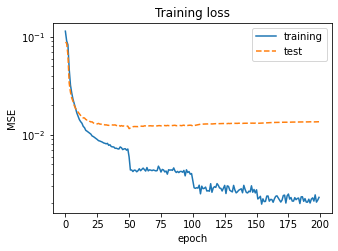

In [145]:
print_freq = 50
#device = torch.device('cuda')
model = main_program_autoenc(imgs_tensor2, labels_tensor2, trainer_info, model_name)

In [146]:
best_model_params = torch.load('model_best.pth.tar', map_location=device)['state_dict']

In [147]:
encoder=Encoder()
decoder=Decoder()
model = Autoencoder(encoder,decoder).to(device)
model.load_state_dict(best_model_params)

<All keys matched successfully>

Text(0.5, 1.0, 'True RVE')

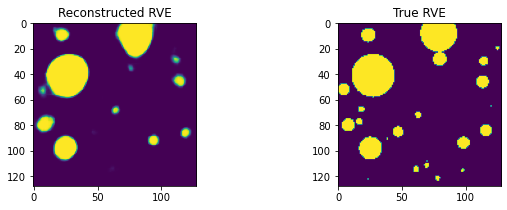

In [151]:
ypred = model(imgs_tensor2[3700:4000]).to(device)

fig,ax=plt.subplots(1,2,figsize=(10,3))
ax[0].imshow(ypred[234,0,:,:].cpu().detach().numpy())
ax[0].set_title('Reconstructed RVE')
ax[1].imshow(imgs_tensor2[3934,0,:,:].cpu().detach().numpy())
ax[1].set_title('True RVE')


In [22]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [149]:
encoder=Encoder().to(device)
Y_latent=encoder(imgs_tensor2)


print(Y_latent.shape)
Y_input_feature=torch.cat((Y_latent,matsp_tensor),dim=1).to(device)

print(Y_input_feature.shape)

torch.Size([4000, 512])
torch.Size([4000, 516])


In [150]:
filename1='Encoded_image.mat'

Encoded={'Encoded':Y_input_feature.cpu().detach().numpy()}


scipy.io.savemat(filename1,Encoded)

filename2='Labels.mat'

labels={'labels':labels_tensor2.cpu().detach().numpy()}


scipy.io.savemat(filename1,Encoded)
scipy.io.savemat(filename2,labels)